# Audio Speech Commands Recognition

* Data Repository: https://upatrasgr-my.sharepoint.com/:u:/g/personal/ceid3565_upatras_gr/EcUKreKCY0tHvjjfma33pkwBTU522U-WKjrRaJgnQ_ghLg?e=2w6Bdd
* The tutorial is based on: https://www.tensorflow.org/tutorials/audio/simple_audio

In [1]:
%load_ext autoreload
%autoreload 2

#### Imports
Disable warnings

In [1]:
import os
# disable TF debug warnings and numpy import 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import yaml
from datetime import datetime
import time

import numpy as np
import tensorflow as tf

import IPython.display as ipd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Disable Warnings for scikit-learn
def warn(*args, **kwargs):
    """Eliminating warnings from scikit-learn.

    """
    pass
import warnings
warnings.warn = warn

In [2]:
now = datetime.now()
print("date and time of NB execution =", now.strftime("%d/%m/%Y %H:%M:%S"))
start_time = time.time()

date and time of NB execution = 22/11/2023 13:44:26


## Load configuration file and dataset path

In [3]:
with open("../config.yml", "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [5]:
# define variables for data path and sample rate
DATASET_PATH = config["PATH"]['RAW']['MINI_SPEECH_COMMANDS']
SAMPLE_RATE = 16000

## Load data 
The audio clips are 1 second or less at 16kHz.

In [6]:
from crossai.loader import audio_loader

# All signals are resampled at `SAMPLE_RATE` and normalised (0, 1)
df = audio_loader(path=DATASET_PATH, sr=SAMPLE_RATE)

Loaded data into the dataframe: 100%|██████████| 2/2 [00:00<00:00, 748.65it/s] 


Create a crossai audio object which will be used for the exploitation of the data processing pipeline.

`cai_audio.data` holds the data in a dataframe: each row/signal is `np.float32`  
and `cai_audio.lalbels` holds the data labels in a dataframe

In [9]:
from crossai.pipelines.audio import Audio

cai_audio = Audio(df)
cai_audio.data.head()

0    [0.506821, 0.50676304, 0.50670505, 0.5071688, ...
1    [0.53376144, 0.5336966, 0.5336966, 0.5336966, ...
2    [0.6036141, 0.6044156, 0.6044885, 0.6037598, 0...
3    [0.4621682, 0.45547011, 0.4510047, 0.44058546,...
4    [0.5535465, 0.5521018, 0.55163574, 0.5524979, ...
Name: data, dtype: object

#### Show audio commands

In [10]:
np.unique(cai_audio.labels)

array(['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes'],
      dtype=object)

#### Pipeline Insertion
- pad all singals to match the maximum one
- scale to [-1, 1] range

The `pad_or_trim` function pads the short ones to exactly 1 second (and would trim longer ones) with 16000 samples per instatnce, so that they can be easily batched.

In [11]:
from crossai.pipelines.timeseries import PadOrTrim
from sklearn.preprocessing import MinMaxScaler
from crossai.pipelines.preparation import Scaler
from sklearn.pipeline import make_pipeline

pot = PadOrTrim(fill_value=0, pad_type='max')
scaler = Scaler(MinMaxScaler(feature_range=(-1, 1)))
pipe = make_pipeline(pot, scaler)
pipe.fit_transform(cai_audio)

## Plot audio waveforms as an example

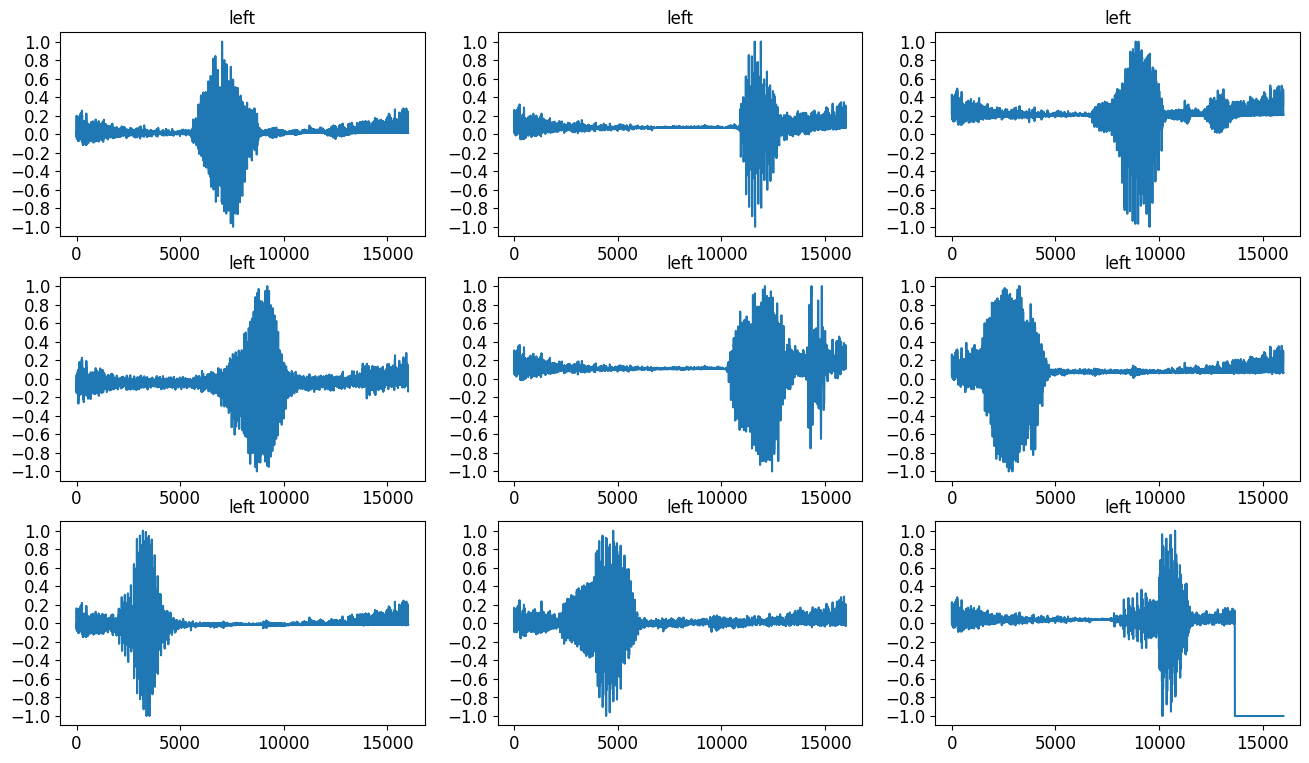

In [12]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(cai_audio.data[i])
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = cai_audio.labels[i]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [13]:
from crossai.processing.audio import melspectrogram

## Convert waveforms to spectrograms

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

* The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
* When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square.
* The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [14]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio

In [15]:
for i in range(3):
  label = cai_audio.labels[i]
  waveform = cai_audio.data[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  ipd.display(ipd.Audio(waveform, rate=16000))

Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


2023-11-19 18:34:03.607014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38198 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:87:00.0, compute capability: 8.0
2023-11-19 18:34:03.608980: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38198 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:8d:00.0, compute capability: 8.0
2023-11-19 18:34:03.610719: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38198 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c7:00.0, compute capability: 8.0


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Define a function for displaying a spectrogram

In [16]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time)

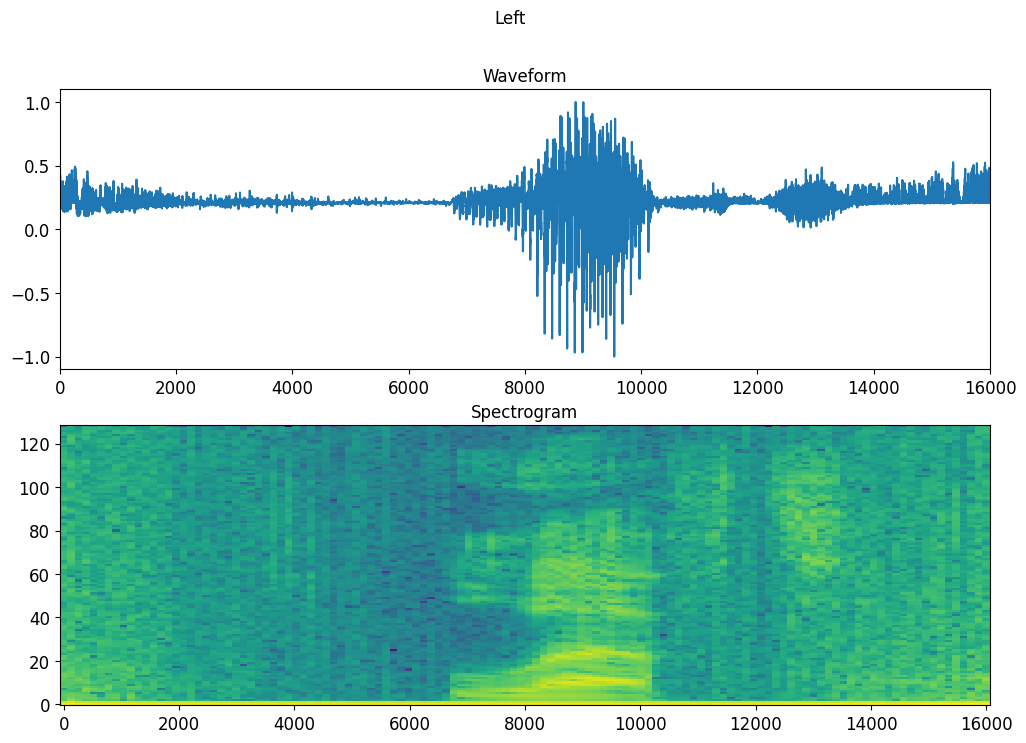

In [17]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram, axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

## Prepare the data for AI analysis

Transform the data into NumPy arrays capable of insertion into the CrossAI's NN models

In [18]:
from crossai.processing import convert_to_model_shape
from sklearn.preprocessing import LabelEncoder

X = convert_to_model_shape(cai_audio.data, model_cat='nn')
y = LabelEncoder().fit_transform(cai_audio.labels)

Define train-test-validation sets

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

Print the transformed data shape

In [20]:
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Validation data shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

print("Labels encoding ready for NN models:", np.unique(cai_audio.labels))

Training data shape: (4800, 16000, 1)
Training labels shape: (4800,)
Validation data shape: (1600, 16000, 1)
Validation labels shape: (1600,)
Test data shape: (1600, 16000, 1)
Test labels shape: (1600,)
Labels encoding ready for NN models: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [21]:
instances, n_features, n_outputs = (X_train.shape[0],
                                    X_train.shape[1],
                                    len(list(np.unique(cai_audio.labels))))

In [22]:
print("Number of instances in the training set:", instances)
print("Number of features (Window size in 1D) in the training set:", n_features)
print("Number of classes:", n_outputs)

Number of instances in the training set: 4800
Number of features (Window size in 1D) in the training set: 16000
Number of classes: 8


## AI Modeling

In [23]:
num_classes = n_outputs

### Simple CNN experimental using the top layer as a model output for classification

In [24]:
from crossai.ai.nn1d import CNN1D

In [25]:
cnn1d = CNN1D(
    input_shape=X_train.shape[1:],
    num_classes=num_classes,
    mc_inference=True
)

Show model summary

In [26]:
cnn1d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 16000, 1)]        0         
                                                                 
 conv1d (Conv1D)             (None, 15998, 64)         256       
                                                                 
 conv1d_1 (Conv1D)           (None, 15996, 64)         12352     
                                                                 
 max_pooling1d (MaxPooling1  (None, 5332, 64)          0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 5330, 128)         24704     
                                                                 
 conv1d_3 (Conv1D)           (None, 5328, 128)         49280     
                                                             

Plot the model to verify the inner structure

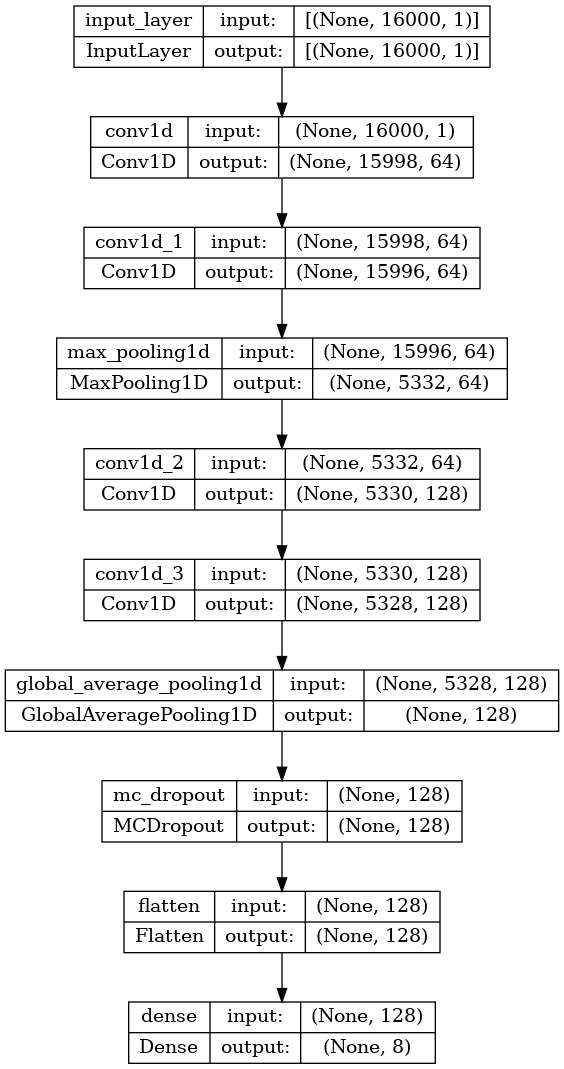

In [27]:
tf.keras.utils.plot_model(cnn1d, to_file='Simple-CNN1D.png', show_shapes=True)

Set up optmizer, compile, and train the model

In [28]:
cnn1d.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [29]:
history = cnn1d.fit(X_train, y_train, batch_size=64, epochs=10, verbose=2, validation_data=(X_val, y_val))

Epoch 1/10


2023-11-19 18:34:15.821467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-19 18:34:16.477642: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-19 18:34:16.782213: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-19 18:34:16.785379: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4640ab29a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-19 18:34:16.785395: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-11-19 18:34:16.785400: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-11-19 18:34:16.785405: I tensorflow/compiler/xla/servi

75/75 - 7s - loss: 2.0767 - sparse_categorical_accuracy: 0.1381 - val_loss: 2.0628 - val_sparse_categorical_accuracy: 0.1587 - 7s/epoch - 99ms/step
Epoch 2/10
75/75 - 2s - loss: 2.0412 - sparse_categorical_accuracy: 0.1865 - val_loss: 2.0149 - val_sparse_categorical_accuracy: 0.2188 - 2s/epoch - 28ms/step
Epoch 3/10
75/75 - 2s - loss: 1.9878 - sparse_categorical_accuracy: 0.2296 - val_loss: 2.0015 - val_sparse_categorical_accuracy: 0.1956 - 2s/epoch - 28ms/step
Epoch 4/10
75/75 - 2s - loss: 1.9622 - sparse_categorical_accuracy: 0.2379 - val_loss: 1.9231 - val_sparse_categorical_accuracy: 0.2850 - 2s/epoch - 29ms/step
Epoch 5/10
75/75 - 2s - loss: 1.8568 - sparse_categorical_accuracy: 0.3025 - val_loss: 1.8244 - val_sparse_categorical_accuracy: 0.2937 - 2s/epoch - 29ms/step
Epoch 6/10
75/75 - 2s - loss: 1.7847 - sparse_categorical_accuracy: 0.3196 - val_loss: 1.7554 - val_sparse_categorical_accuracy: 0.3406 - 2s/epoch - 28ms/step
Epoch 7/10
75/75 - 2s - loss: 1.7412 - sparse_categorical

Show history info

In [30]:
history.params

{'verbose': 2, 'epochs': 10, 'steps': 75}

In [31]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

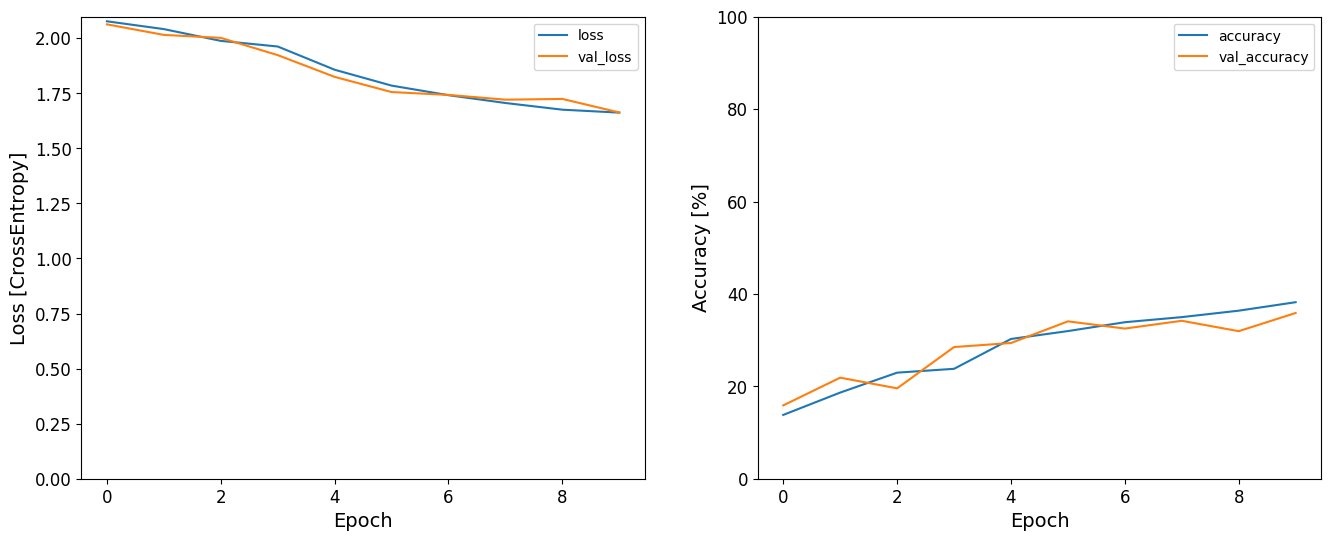

In [32]:
def plot_learning(history):
    metrics = history.history
    history_keys = list(history.history.keys())
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.epoch, metrics[history_keys[0]], metrics[history_keys[2]])
    plt.legend(['loss', 'val_loss'])
    plt.ylim([0, max(plt.ylim())])
    plt.xlabel('Epoch')
    plt.ylabel('Loss [CrossEntropy]')

    plt.subplot(1,2,2)
    plt.plot(history.epoch, 100*np.array(metrics[history_keys[1]]), 100*np.array(metrics[history_keys[3]]))
    plt.legend(['accuracy', 'val_accuracy'])
    plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')

plot_learning(history)

Evaluate the model on test data

In [33]:
cnn1d.evaluate(X_test, y_test, return_dict=True)

50/50 [==============================] - 1s 6ms/step - loss: 1.6483 - sparse_categorical_accuracy: 0.3762


{'loss': 1.6483142375946045, 'sparse_categorical_accuracy': 0.3762499988079071}

### XceptionTime using the top layer as a model output for classification

In [34]:
from crossai.ai.nn1d import XceptionTime

Build the model. By TF convention, drop batch size (number of instances) dimension

In [35]:
xception_time = XceptionTime(
    input_shape=X_train.shape[1:],
    num_classes=num_classes,
    mc_inference=True
)

Input size W of window transformed into a fixed length of         4000 sample for AAP mid layer.


Show model summary

In [36]:
xception_time.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 16000, 1)]           0         []                            
                                                                                                  
 mc_dropout_1 (MCDropout)    (None, 16000, 1)             0         ['input_layer[0][0]']         
                                                                                                  
 conv1d_4 (Conv1D)           (None, 16000, 16)            16        ['mc_dropout_1[0][0]']        
                                                                                                  
 max_pooling1d_1 (MaxPoolin  (None, 16000, 1)             0         ['mc_dropout_1[0][0]']        
 g1D)                                                                                       

Plot the model to verify the inner structure

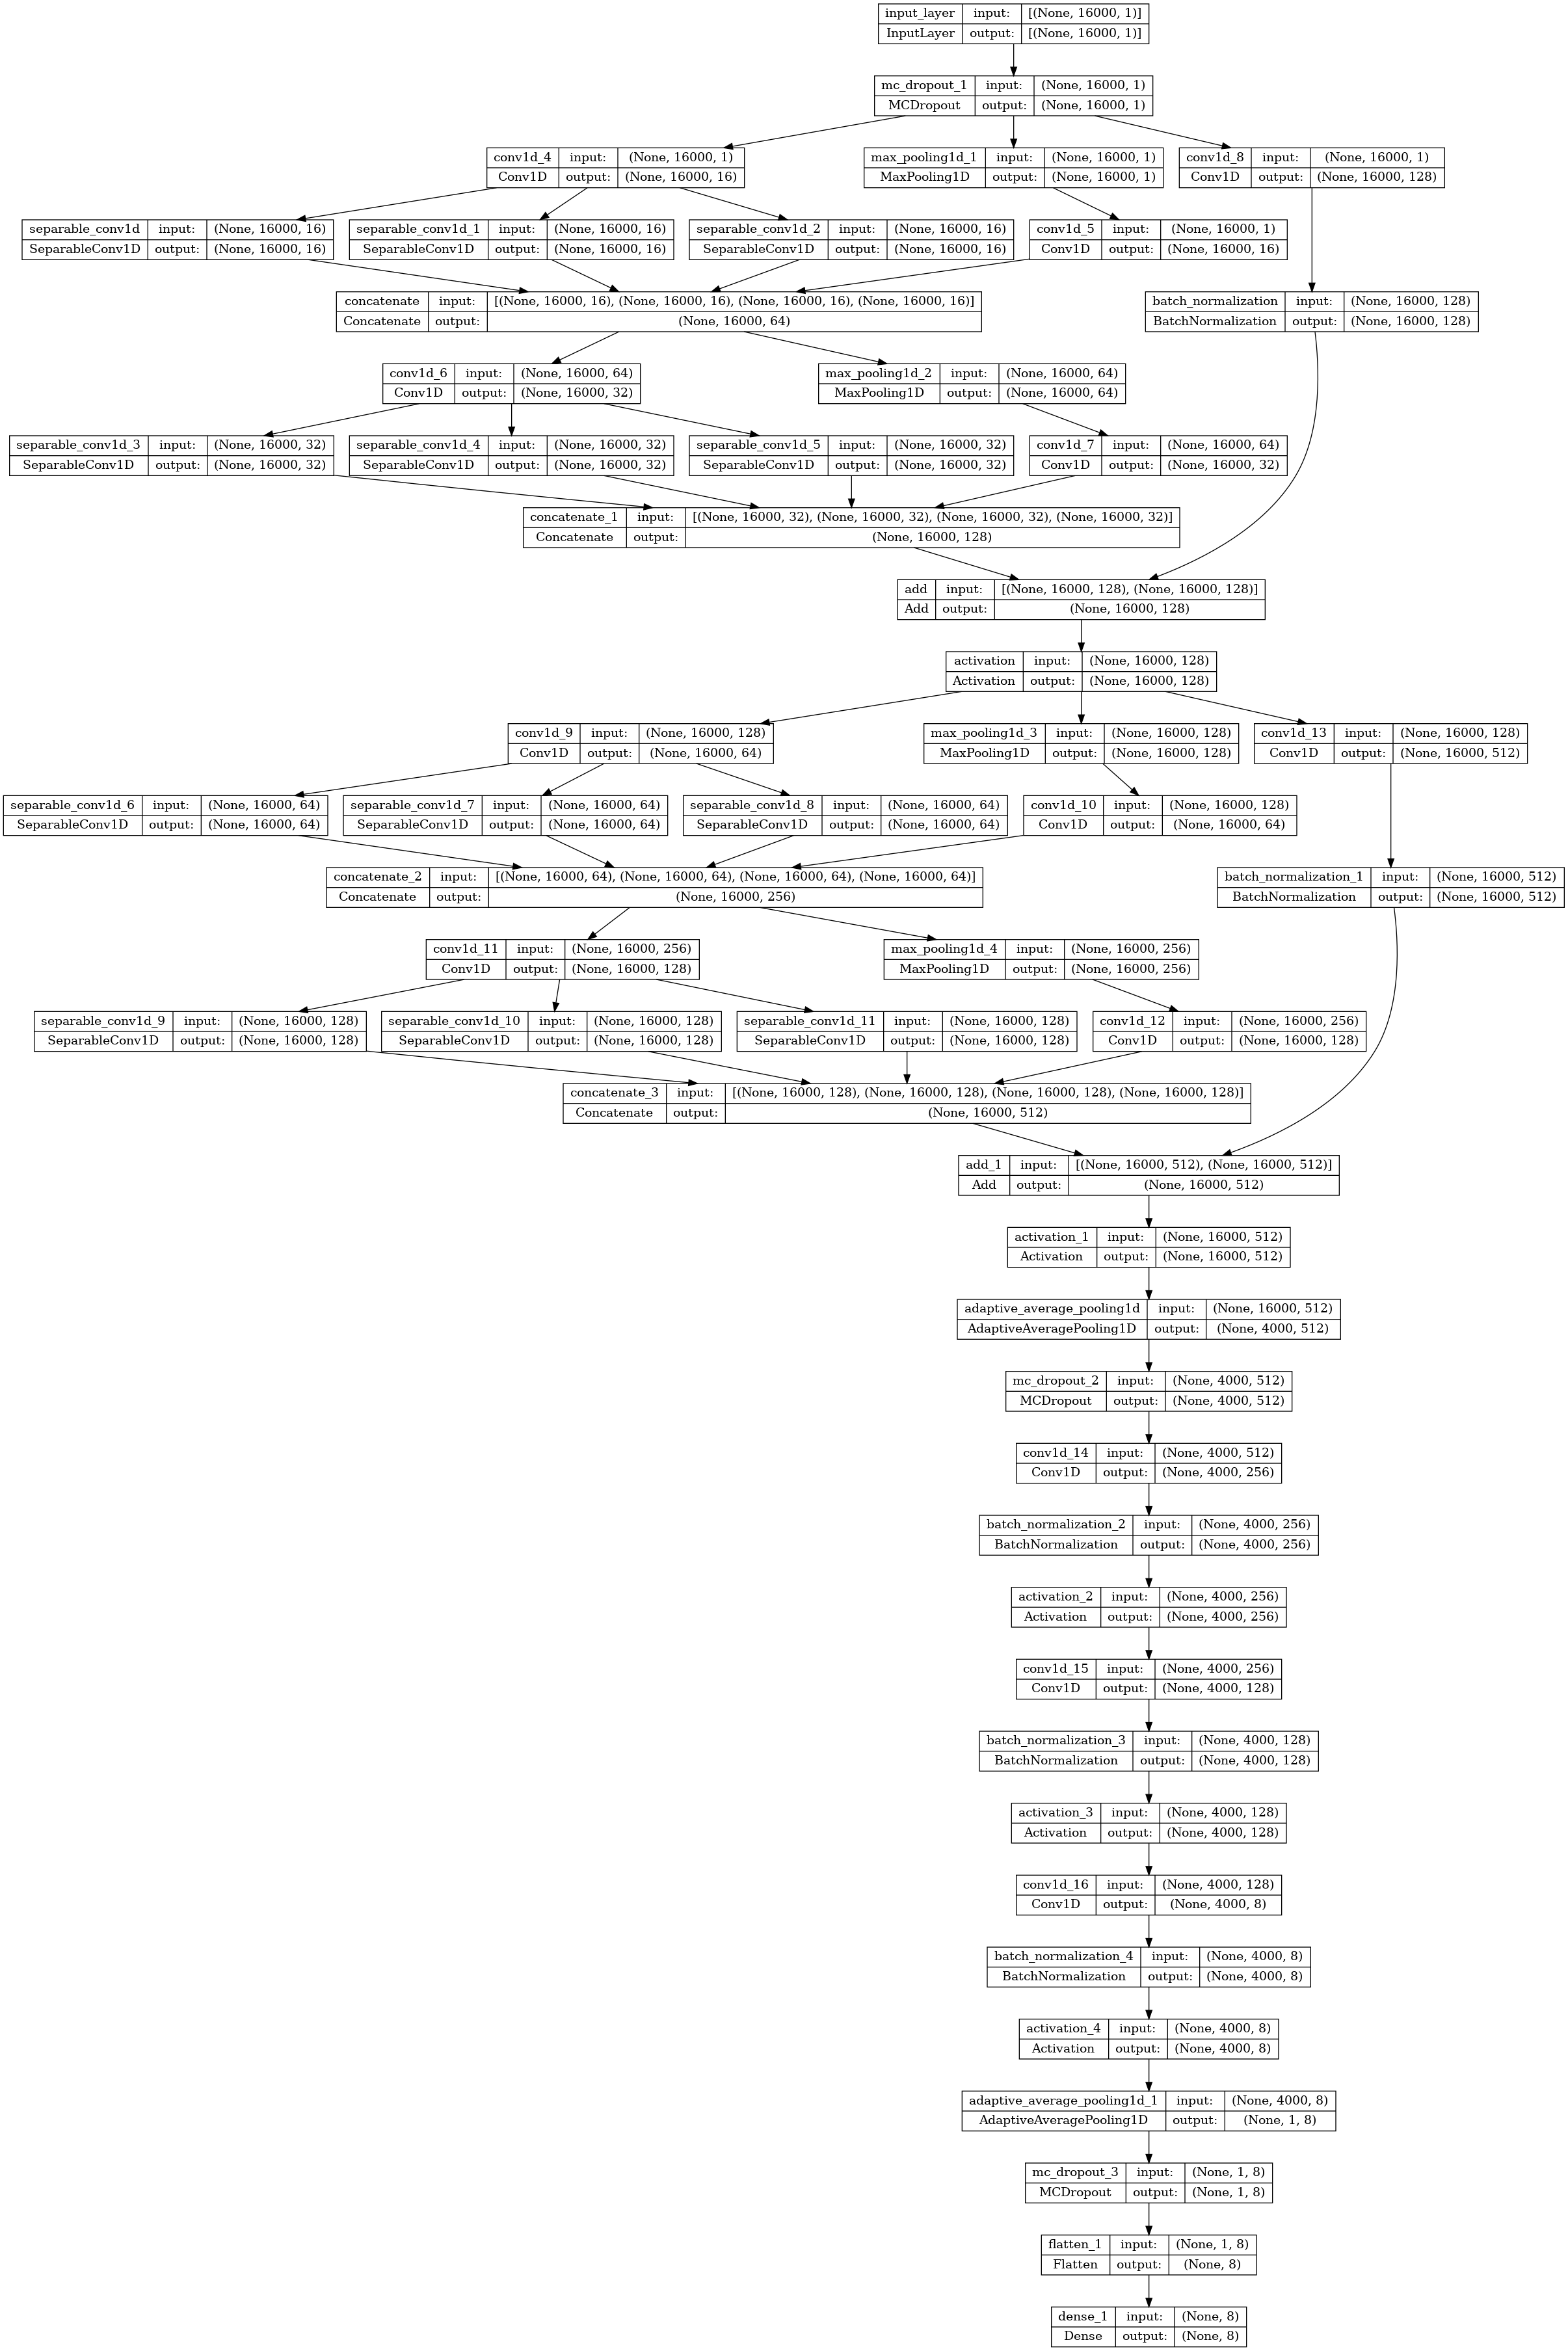

In [37]:
tf.keras.utils.plot_model(xception_time, to_file='XceptionTime.png', show_shapes=True)

Set up optmizer, compile, and train the model

In [38]:
xception_time.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [39]:
history = xception_time.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_val, y_val))

Epoch 1/10
75/75 [==============================] - 51s 515ms/step - loss: 2.1303 - sparse_categorical_accuracy: 0.1240 - val_loss: 2.1006 - val_sparse_categorical_accuracy: 0.1612
Epoch 2/10
75/75 [==============================] - 38s 504ms/step - loss: 2.0733 - sparse_categorical_accuracy: 0.1600 - val_loss: 2.0765 - val_sparse_categorical_accuracy: 0.1600
Epoch 3/10
75/75 [==============================] - 38s 504ms/step - loss: 2.0234 - sparse_categorical_accuracy: 0.2317 - val_loss: 2.0537 - val_sparse_categorical_accuracy: 0.2375
Epoch 4/10
75/75 [==============================] - 38s 505ms/step - loss: 1.9669 - sparse_categorical_accuracy: 0.2844 - val_loss: 1.9547 - val_sparse_categorical_accuracy: 0.3150
Epoch 5/10
75/75 [==============================] - 38s 507ms/step - loss: 1.8909 - sparse_categorical_accuracy: 0.3756 - val_loss: 1.9330 - val_sparse_categorical_accuracy: 0.2794
Epoch 6/10
75/75 [==============================] - 38s 507ms/step - loss: 1.8145 - sparse_cate

Show history info

In [40]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 75}

In [41]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

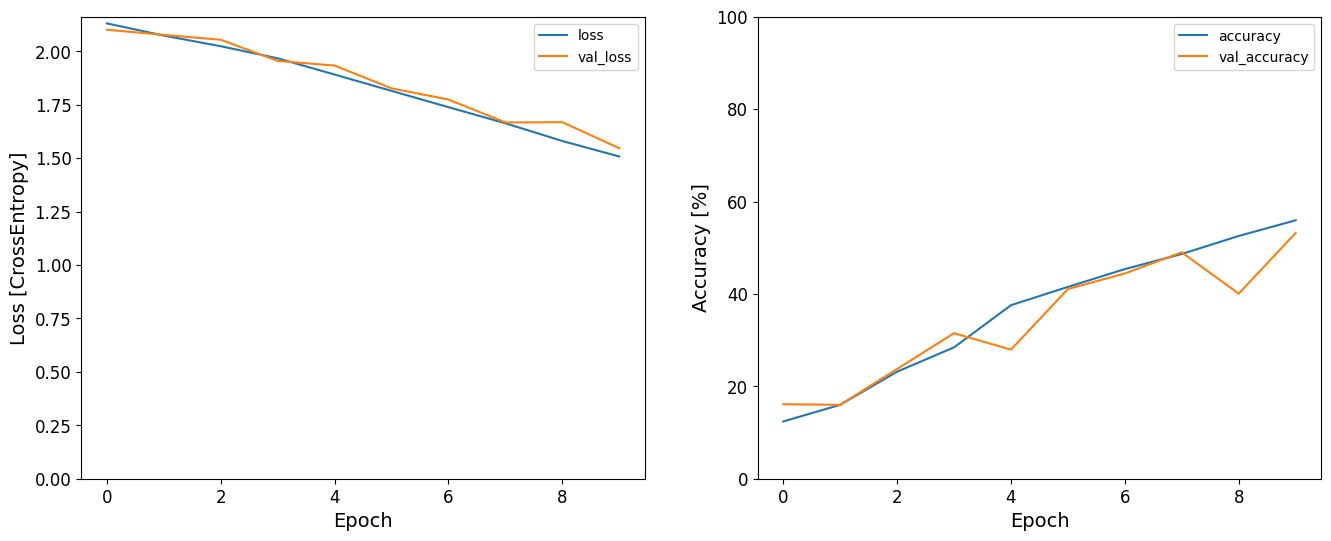

In [42]:
plot_learning(history)

Evaluate the model on test data

In [43]:
xception_time.evaluate(X_test, y_test, return_dict=True)

50/50 [==============================] - 3s 46ms/step - loss: 1.5424 - sparse_categorical_accuracy: 0.5481


{'loss': 1.542363166809082, 'sparse_categorical_accuracy': 0.5481250286102295}

### InceptionTime extended by new layers on top of the main architecture

In [44]:
from crossai.ai.nn1d import InceptionTime

In [45]:
inception_time = InceptionTime(
    input_shape=X_train.shape[1:],
    num_classes=num_classes,
    mc_inference=True
)

kernel size list:  [40, 20, 10]
Inception filters: 32 - kernel: 40
Inception filters: 32 - kernel: 20
Inception filters: 32 - kernel: 10
kernel size list:  [40, 20, 10]
Inception filters: 32 - kernel: 40
Inception filters: 32 - kernel: 20
Inception filters: 32 - kernel: 10
kernel size list:  [40, 20, 10]
Inception filters: 32 - kernel: 40
Inception filters: 32 - kernel: 20
Inception filters: 32 - kernel: 10
kernel size list:  [40, 20, 10]
Inception filters: 32 - kernel: 40
Inception filters: 32 - kernel: 20
Inception filters: 32 - kernel: 10
kernel size list:  [40, 20, 10]
Inception filters: 32 - kernel: 40
Inception filters: 32 - kernel: 20
Inception filters: 32 - kernel: 10
kernel size list:  [40, 20, 10]
Inception filters: 32 - kernel: 40
Inception filters: 32 - kernel: 20
Inception filters: 32 - kernel: 10


Set up the new layers

In [46]:
x = tf.keras.layers.Flatten()(inception_time.output)
output = tf.keras.layers.Dense(units=num_classes, activation=tf.keras.activations.softmax)(x)

inception_time_ext = tf.keras.Model(inputs=inception_time.input, outputs=output)

Show model summary

In [47]:
inception_time_ext.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 16000, 1)]           0         []                            
                                                                                                  
 mc_dropout_4 (MCDropout)    (None, 16000, 1)             0         ['input_layer[0][0]']         
                                                                                                  
 conv1d_17 (Conv1D)          (None, 16000, 32)            32        ['mc_dropout_4[0][0]']        
                                                                                                  
 max_pooling1d_5 (MaxPoolin  (None, 16000, 1)             0         ['mc_dropout_4[0][0]']        
 g1D)                                                                                       

Plot the model to verify the inner structure

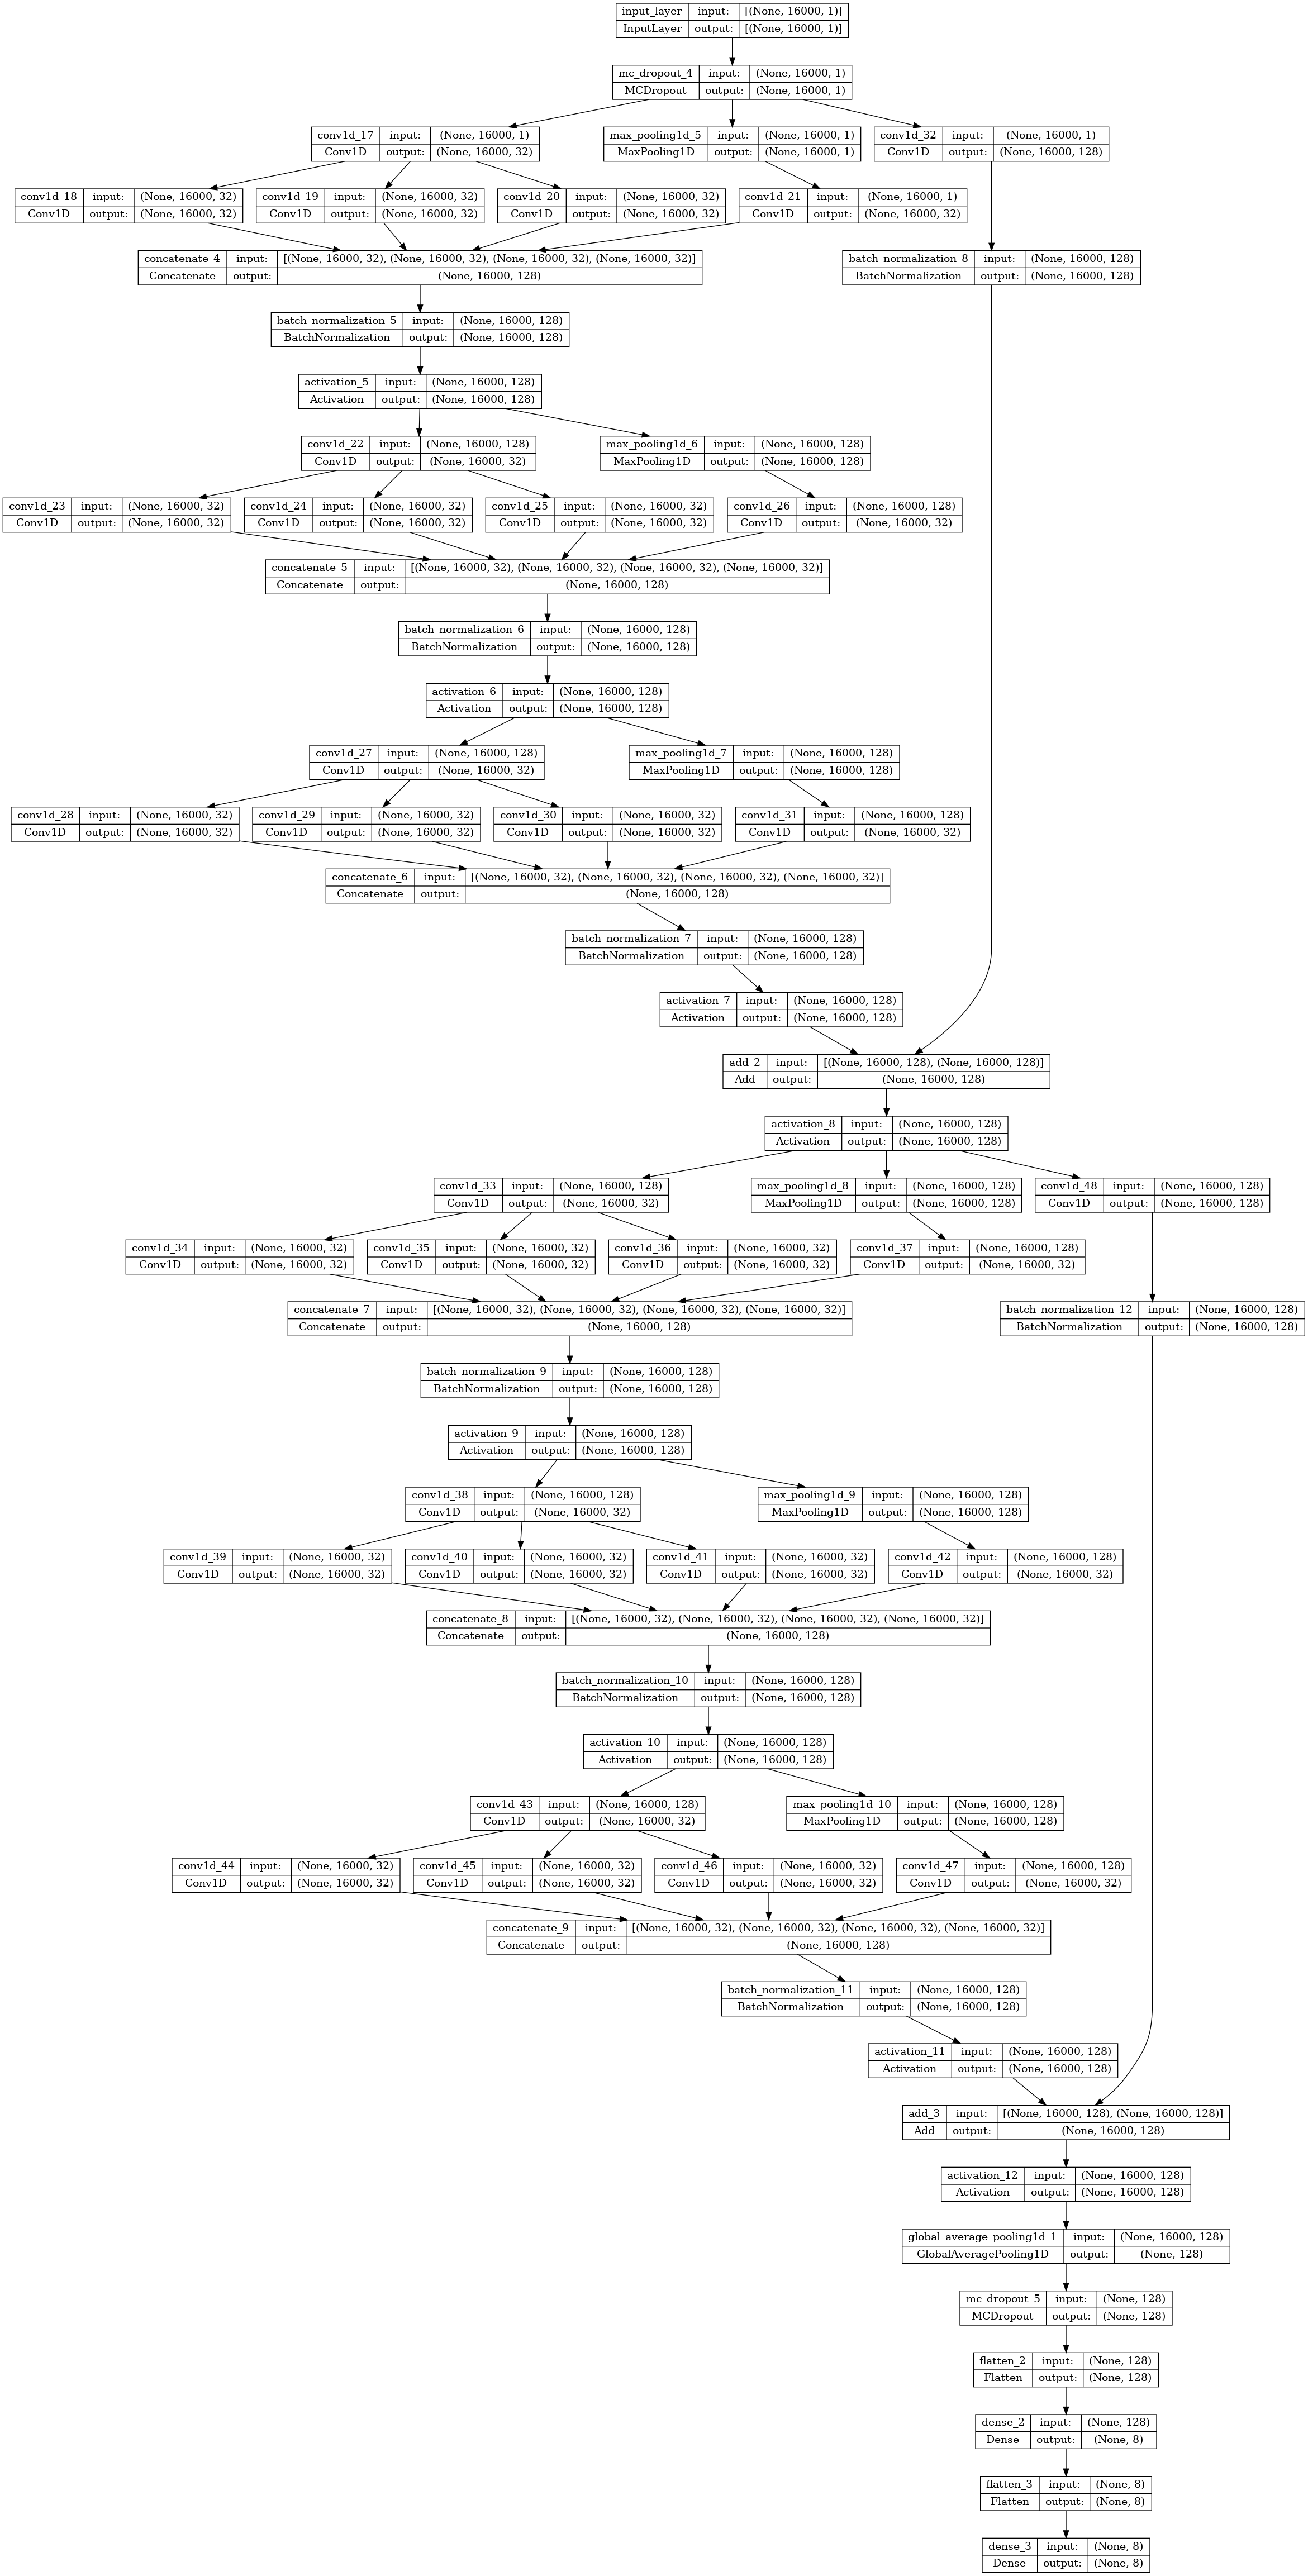

In [48]:
tf.keras.utils.plot_model(inception_time_ext, to_file='InceptionTime-Extented.png', show_shapes=True)

Set up optmizer, compile, and train the model

In [49]:
inception_time_ext.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [50]:
history = inception_time_ext.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_val, y_val))

Epoch 1/10
75/75 [==============================] - 43s 456ms/step - loss: 2.1378 - sparse_categorical_accuracy: 0.2017 - val_loss: 2.1727 - val_sparse_categorical_accuracy: 0.1262
Epoch 2/10
75/75 [==============================] - 33s 437ms/step - loss: 2.0243 - sparse_categorical_accuracy: 0.3133 - val_loss: 2.1686 - val_sparse_categorical_accuracy: 0.1244
Epoch 3/10
75/75 [==============================] - 33s 437ms/step - loss: 1.9453 - sparse_categorical_accuracy: 0.3388 - val_loss: 2.1642 - val_sparse_categorical_accuracy: 0.1287
Epoch 4/10
75/75 [==============================] - 33s 437ms/step - loss: 1.8916 - sparse_categorical_accuracy: 0.3452 - val_loss: 2.1761 - val_sparse_categorical_accuracy: 0.1331
Epoch 5/10
75/75 [==============================] - 33s 436ms/step - loss: 1.8467 - sparse_categorical_accuracy: 0.3544 - val_loss: 2.0488 - val_sparse_categorical_accuracy: 0.2269
Epoch 6/10
75/75 [==============================] - 33s 437ms/step - loss: 1.8089 - sparse_cate

Show history info

In [51]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 75}

In [52]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

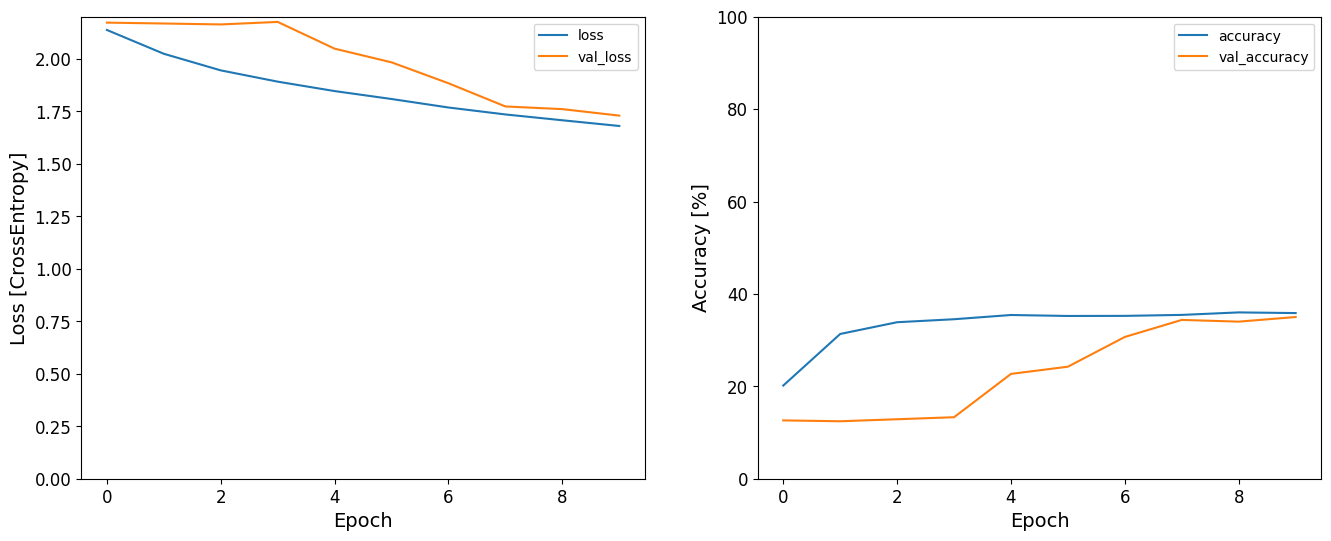

In [53]:
plot_learning(history)

Evaluate the model on test data

In [54]:
inception_time_ext.evaluate(X_test, y_test, return_dict=True)

50/50 [==============================] - 4s 49ms/step - loss: 1.7111 - sparse_categorical_accuracy: 0.3594


{'loss': 1.7111164331436157, 'sparse_categorical_accuracy': 0.359375}

### BiLSTM-Time using the top layer as a model output for classification

In [55]:
from crossai.ai.nn1d import BiLSTM_Time

In [56]:
bilstm_time = BiLSTM_Time(
    input_shape=X_train.shape[1:],
    num_classes=num_classes,
    mc_inference=True)

Show model summary

In [57]:
bilstm_time.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 16000, 1)]        0         
                                                                 
 bidirectional (Bidirection  (None, 16000, 64)         8704      
 al)                                                             
                                                                 
 mc_dropout_6 (MCDropout)    (None, 16000, 64)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 16000, 64)         24832     
 onal)                                                           
                                                                 
 mc_dropout_7 (MCDropout)    (None, 16000, 64)         0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                2483

Plot the model to verify the inner structure

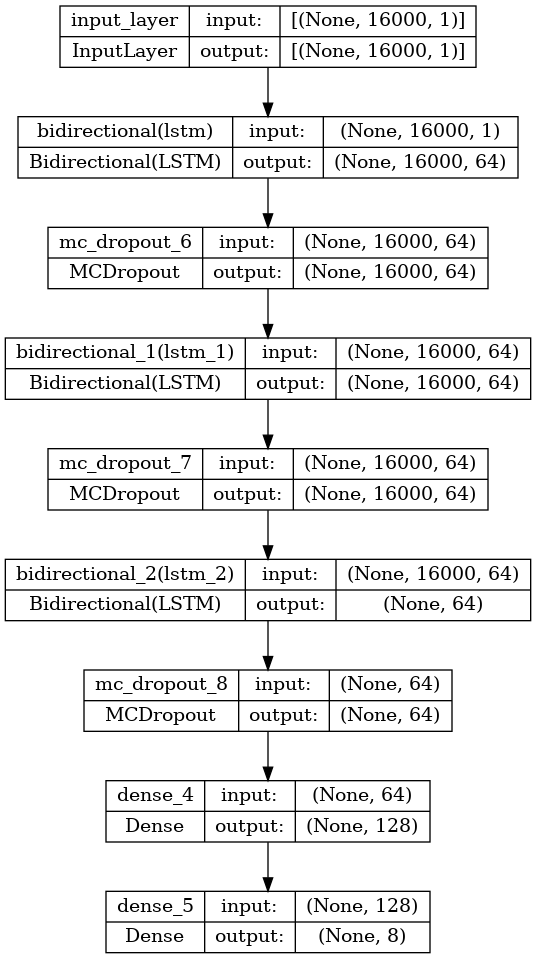

In [58]:
tf.keras.utils.plot_model(bilstm_time, to_file='BiLSTM-Time.png', show_shapes=True)

Set up optmizer, compile, and train the model

In [59]:
bilstm_time.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [60]:
history = bilstm_time.fit(X_train, y_train, batch_size=64, epochs=10, verbose=2, validation_data=(X_val, y_val))

Epoch 1/10
75/75 - 203s - loss: 2.0795 - sparse_categorical_accuracy: 0.1204 - val_loss: 2.0789 - val_sparse_categorical_accuracy: 0.1388 - 203s/epoch - 3s/step
Epoch 2/10
75/75 - 195s - loss: 2.0772 - sparse_categorical_accuracy: 0.1331 - val_loss: 2.0799 - val_sparse_categorical_accuracy: 0.1319 - 195s/epoch - 3s/step
Epoch 3/10
75/75 - 195s - loss: 2.0766 - sparse_categorical_accuracy: 0.1377 - val_loss: 2.0813 - val_sparse_categorical_accuracy: 0.1187 - 195s/epoch - 3s/step
Epoch 4/10
75/75 - 192s - loss: 2.0755 - sparse_categorical_accuracy: 0.1419 - val_loss: 2.0805 - val_sparse_categorical_accuracy: 0.1244 - 192s/epoch - 3s/step
Epoch 5/10
75/75 - 192s - loss: 2.0753 - sparse_categorical_accuracy: 0.1406 - val_loss: 2.0804 - val_sparse_categorical_accuracy: 0.1369 - 192s/epoch - 3s/step
Epoch 6/10
75/75 - 195s - loss: 2.0749 - sparse_categorical_accuracy: 0.1381 - val_loss: 2.0819 - val_sparse_categorical_accuracy: 0.1406 - 195s/epoch - 3s/step
Epoch 7/10
75/75 - 194s - loss: 2.

Show history info

In [61]:
history.params

{'verbose': 2, 'epochs': 10, 'steps': 75}

In [62]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

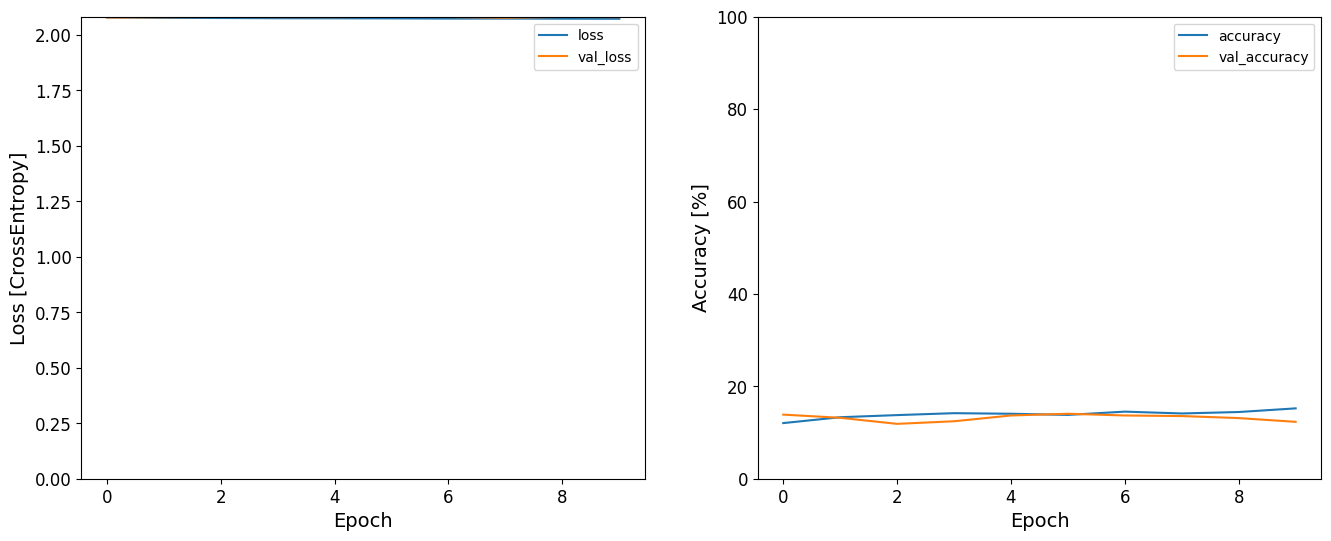

In [63]:
plot_learning(history)

Evaluate the model on test data

In [64]:
bilstm_time.evaluate(X_test, y_test, return_dict=True)

50/50 [==============================] - 55s 1s/step - loss: 2.0774 - sparse_categorical_accuracy: 0.1269


{'loss': 2.077441930770874, 'sparse_categorical_accuracy': 0.12687499821186066}

## Time of execution of the NB processing

In [65]:
print("Time of execution:", (time.time() - start_time) / 60, "minutes")

Time of execution: 46.80590629577637 minutes
